# Acknowledgement

I completed this project with my Learning Team, which consisted of Erika Lacson, Cyril Benedict Lugod, and Ramon Martin Militar.

In [1]:
# Importing necessary libraries
import psycopg2
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler



# GSA
from scipy.spatial import KDTree
from sklearn.neighbors import BallTree
import folium
from folium.features import DivIcon
from shapely.geometry import Point

# Preprocessing
from sklearn.preprocessing import StandardScaler


# Clustering
from sklearn.cluster import (KMeans, AgglomerativeClustering, DBSCAN, OPTICS,
                             cluster_optics_dbscan)
from sklearn.metrics import (silhouette_score, calinski_harabasz_score,
                             davies_bouldin_score)
from scipy.cluster.hierarchy import dendrogram
from fastcluster import linkage


# Filter warnings
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

In [2]:
import osmnx as ox
import networkx as nx
import pandas as pd
from skimage.graph import MCP_Geometric
import numpy as np
import networkx as nx
import osmnx as ox
import pickle
import folium
import requests
import json
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from sklearn.neighbors import BallTree
from shapely.wkt import loads

In [3]:

# query = '''
#     SELECT *
#     FROM gadm.ph_brgy
# '''
# ph_brgy_shape = gpd.read_postgis(query, conn, geom_col='geom')
with open('pickles/ph_brgy_shape.pkl', 'rb') as f:
    ph_brgy_shape = pickle.load(f)

armm_brgy_shape = ph_brgy_shape[ph_brgy_shape['name_1'].isin(
    ['Lanao del Sur', 'Maguindanao', 'Basilan', 'Sulu', 'Tawi-Tawi'])]
armm_brgy_shape['name_2'] = armm_brgy_shape['name_2'].str.upper()
armm_brgy_shape['name_3'] = armm_brgy_shape['name_3'].str.upper()
armm_brgy_shape['land_area'] = armm_brgy_shape.area

# query = '''
#     SELECT
#         p.amenity,
#         p.name,
#         g.name_1,
#         g.name_2,
#         g.name_3,
#         p.way
#     FROM
#         ph_point p
#     JOIN
#         gadm.ph_brgy g
#     ON
#         ST_Within(p.way, g.geom)
#     WHERE
#         p.amenity IS NOT NULL AND
#         g.name_1 IN ('Lanao del Sur', 'Maguindanao', 'Basilan', 'Sulu', 'Tawi-Tawi')
# '''
# armm_pts = gpd.read_postgis(query, conn, geom_col='way')

with open('pickles/armm_pts.pkl', 'rb') as f:
    armm_pts = pickle.load(f)

health_fac = ['hospital', 'doctors', 'clinic',
              'district hospital', 'health_facility']
armm_health_pts = armm_pts[armm_pts['amenity'].isin(health_fac)]

# Load your data files here instead of using the 'data' folder
df_brgy_solar = pd.read_csv('data/Barangays_Solar_Data.csv')
df_brgy_solar['NAME_2'] = df_brgy_solar['NAME_2'].str.upper()
df_brgy_solar['NAME_3'] = df_brgy_solar['NAME_3'].str.upper()

df_brgy_solar_armm = df_brgy_solar[df_brgy_solar.REGION ==
                                   'Autonomous Region of Muslim Mindanao (ARMM)']

armm_solar_shp = armm_brgy_shape.merge(df_brgy_solar_armm, left_on=[
    'name_2', 'name_3'], right_on=['NAME_2', 'NAME_3'])

# Load your data files here instead of using the 'data' folder
df_basilan_pop = pd.read_excel('BARMM.xlsx', sheet_name='basilan')
df_lanaodelsur_pop = pd.read_excel(
    'BARMM.xlsx', sheet_name='lanao del sur')
df_maguindanao_pop = pd.read_excel('BARMM.xlsx', sheet_name='maguindanao')
df_sulu_pop = pd.read_excel('BARMM.xlsx', sheet_name='sulu')
df_tawitawi_pop = pd.read_excel('BARMM.xlsx', sheet_name='tawi-tawi')
df_armm_pop = pd.concat([df_basilan_pop, df_lanaodelsur_pop,
                        df_maguindanao_pop, df_sulu_pop, df_tawitawi_pop])
df_armm_pop['name_2'] = df_armm_pop['name_2'].str.upper()
df_armm_pop['name_3'] = df_armm_pop['name_3'].str.upper()

armm_pop_shape = armm_brgy_shape.merge(
    df_armm_pop, left_on=['name_2', 'name_3'], right_on=['name_2', 'name_3'])
armm_pop_shape['log_pop'] = np.log(armm_pop_shape['pop'])

armm_prov_list = ['Lanao del Sur', 'Maguindanao',
                  'Basilan', 'Sulu', 'Tawi-Tawi']

# Merge armm_solar_shp and armm_pop_shape
df_clustering = armm_solar_shp.merge(
    armm_pop_shape[['name_2', 'name_3', 'pop', 'log_pop']], on=['name_2', 'name_3'])

barmm
#REF
tawi-tawi
#REF
lanao del sur
#REF
barmm
#REF
tawi-tawi
#REF
lanao del sur
#REF
barmm
#REF
tawi-tawi
#REF
lanao del sur
#REF
barmm
#REF
tawi-tawi
#REF
lanao del sur
#REF
barmm
#REF
tawi-tawi
#REF
lanao del sur
#REF


In [4]:
df = df_clustering.copy()
columns = ['name_1', 'name_2', 'name_3', 'geom', 'pop', 'log_pop', 'PVOUT_mean', 'land_area']
df = df[columns]
df['pop_density'] = df['pop'] / df['land_area']

In [5]:


# Create a GeoDataFrame from the DataFrame
gdf = gpd.GeoDataFrame(df.copy(), geometry='geom', crs="EPSG:4326")

# List of points
points_list = armm_health_pts.way
first_point = points_list.iloc[0]
utm_zone = int((first_point.x + 180) / 6) + 1
utm_crs = f"EPSG:326{utm_zone:02d}" if first_point.y >= 0 else f"EPSG:327{utm_zone:02d}"

# Convert the GeoDataFrame to the UTM projection
gdf_utm = gdf.to_crs(utm_crs)

# Create a BallTree instance
ball_tree = BallTree(np.array([point_utm.coords[0] for point_utm in gdf_utm.geometry.centroid]), metric='euclidean')

# Function to count points within a 500-meter radius
def count_points_within_radius(ball_tree, point, radius):
    return ball_tree.query_radius(point.reshape(1, -1), r=radius, count_only=True)[0]

# Count how many times each point is within a 500-meter radius of the geometries and create a new column for each point
for idx, point in enumerate(points_list, start=1):
    point_gdf = gpd.GeoDataFrame(geometry=[point], crs="EPSG:4326")
    point_utm = point_gdf.to_crs(utm_crs).geometry.iloc[0]
    point_coords = np.array(point_utm.coords[0])
    
    gdf[armm_health_pts['name'].values[idx-1]] = [
        count_points_within_radius(ball_tree, point_coords, 10000) if geom.contains(point) else 0
        for geom in gdf.geometry
    ]

# Print the result
gdf.head(1)


,name_1,name_2,name_3,geom,pop,log_pop,PVOUT_mean,land_area,pop_density,Alano's Hospital,Infante Hospital,Amai Pakpak Medical Center,Wao District Hospital,Cotabato Medical Plaza,Red Cross,Cotabato Doctors Clinic,Cotabato Polymedic & Diagnostic Center,CMRC Outpatient Department,Tamontaka 4 Health Office,IPHO Maguondanao,Cotabato Medical Specialist Center,Specialist Clinic & Laboratory,Cotabato Sanitarium Hospital,Datu Blah T. Sinsuat District Hospital,Clinica Pambata,Philippine Red Cross - Sulu,Pangutaran District Hospital,Pangutaran Rural Health Unit,Medical Specialist Polyclinic,Sibutu Hospital
0,Basilan,AL-BARKA,MAGCAWA,"MULTIPOLYGON (((122.12465 6.54958, 122.12728 6...",2349,7.761745,1317.018518,0.000715,3.284328e+06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
df_brgy_hosp_pop = gdf.copy()

In [7]:
# Get the columns from the 8th column onwards
columns_to_process = df_brgy_hosp_pop.columns[9:30]

# Calculate the row-wise sum of 1 values from column 8 onwards
df_brgy_hosp_pop["rowwise_sum"] = df_brgy_hosp_pop[columns_to_process].sum(axis=1)

# Calculate the population divided by the row-wise sum and store the result in a new column
df_brgy_hosp_pop["pop_rowwise_ratio"] = df_brgy_hosp_pop["pop_density"] / df_brgy_hosp_pop["rowwise_sum"].replace(0, 1)

columns_to_process = df_brgy_hosp_pop.columns[9:30]
for col in columns_to_process:
    df_brgy_hosp_pop[col] = df_brgy_hosp_pop.apply(lambda row: row["pop_rowwise_ratio"] if row[col] == 1 else row[col], axis=1)

# Print the result
df_brgy_hosp_pop.head(1)



,name_1,name_2,name_3,geom,pop,log_pop,PVOUT_mean,land_area,pop_density,Alano's Hospital,Infante Hospital,Amai Pakpak Medical Center,Wao District Hospital,Cotabato Medical Plaza,Red Cross,Cotabato Doctors Clinic,Cotabato Polymedic & Diagnostic Center,CMRC Outpatient Department,Tamontaka 4 Health Office,IPHO Maguondanao,Cotabato Medical Specialist Center,Specialist Clinic & Laboratory,Cotabato Sanitarium Hospital,Datu Blah T. Sinsuat District Hospital,Clinica Pambata,Philippine Red Cross - Sulu,Pangutaran District Hospital,Pangutaran Rural Health Unit,Medical Specialist Polyclinic,Sibutu Hospital,rowwise_sum,pop_rowwise_ratio
0,Basilan,AL-BARKA,MAGCAWA,"MULTIPOLYGON (((122.12465 6.54958, 122.12728 6...",2349,7.761745,1317.018518,0.000715,3.284328e+06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.284328e+06


In [8]:
df_brgy_hosp_pop_sum = df_brgy_hosp_pop.sum()
df_hospital_pop = df_brgy_hosp_pop_sum[8:29].reset_index()
new_column_names = {'index': 'Hospital Name', 0: 'Population'}
df_hospital_pop = df_hospital_pop.rename(columns=new_column_names)
df_hospital_pop.head(1)

,Hospital Name,Population
0,Alano's Hospital,46


In [9]:
df_hospitals = armm_health_pts.copy()
df_hospitals['name_2'] = df_hospitals['name_2'].str.upper()
df_hospitals['name_3'] = df_hospitals['name_3'].str.upper()
df_clusters = df_hospitals.merge(df, left_on=['name_1', 'name_2', 'name_3'], right_on=['name_1','name_2', 'name_3'], how='left')
df_clusters.head(1)

,amenity,name,name_1,name_2,name_3,way,geom,pop,log_pop,PVOUT_mean,land_area,pop_density
0,hospital,Alano's Hospital,Basilan,ISABELA CITY,RIVERSIDE,POINT (121.96939 6.69963),"MULTIPOLYGON (((121.96845 6.69039, 121.96828 6...",1883.0,7.540622,1392.697998,0.000114,1.652815e+07


In [10]:
meters=20000
PVOUT_weight=0.70
pop_served_weight=0.30
df_cleaned = pd.concat([df_clusters, df_hospital_pop], axis=1)
df_cleaned['score'] = PVOUT_weight * (df_cleaned['PVOUT_mean'] * df_cleaned['land_area'] ) + \
    pop_served_weight * df_cleaned['Population']
df_cleaned['Population'] = df_cleaned['Population'].astype(float)
df_cleaned['score'] = df_cleaned['score'].astype(float)
df_cleaned.head(5)

,amenity,name,name_1,name_2,name_3,way,geom,pop,log_pop,PVOUT_mean,land_area,pop_density,Hospital Name,Population,score
0,hospital,Alano's Hospital,Basilan,ISABELA CITY,RIVERSIDE,POINT (121.96939 6.69963),"MULTIPOLYGON (((121.96845 6.69039, 121.96828 6...",1883.0,7.540622,1392.697998,0.000114,1.652815e+07,Alano's Hospital,46.0,13.911066
1,hospital,Infante Hospital,Basilan,ISABELA CITY,SEASIDE,POINT (121.97293 6.70523),"MULTIPOLYGON (((121.98318 6.70503, 121.98183 6...",328.0,5.793014,1410.177601,0.000107,3.078716e+06,Infante Hospital,48.0,14.505166
2,hospital,Amai Pakpak Medical Center,Lanao del Sur,MARAWI CITY,MARINAUT EAST,POINT (124.28409 8.00463),"MULTIPOLYGON (((124.28765 8.00623, 124.28576 8...",1108.0,7.010312,1378.816503,0.000009,1.248634e+08,Amai Pakpak Medical Center,239.0,71.708565
3,hospital,Wao District Hospital,Lanao del Sur,WAO,PILINTANGAN,POINT (124.72208 7.63817),"MULTIPOLYGON (((124.76394 7.62246, 124.76712 7...",2028.0,7.614805,1480.155423,0.000541,3.750654e+06,Wao District Hospital,28.0,8.960230
4,doctors,Cotabato Medical Plaza,Maguindanao,COTABATO CITY,TAMONTAKA,POINT (124.25032 7.22081),"MULTIPOLYGON (((124.24844 7.21804, 124.24902 7...",14099.0,9.553859,1578.655185,0.000010,1.395141e+09,Cotabato Medical Plaza,74.0,22.211167


In [11]:

# Define the variable to pickle
armm_center_geom = armm_pop_shape.unary_union.centroid
armm_center = [armm_center_geom.y, armm_center_geom.x]

file_path = './pickles/folium_center.pkl'

# Pickle the data to the file
with open(file_path, 'wb') as f:
    pickle.dump(armm_center, f)

In [12]:

# Get the top 5 locations

top_5_locations = df_cleaned.nlargest(5, 'land_area').reset_index()

# Plot the top 5 locations on a map
colors = ['red', 'blue', 'green', 'purple', 'orange']

armm_center_geom = armm_pop_shape.unary_union.centroid
armm_center = [armm_center_geom.y, armm_center_geom.x]


overlay = folium.Map(location=armm_center, zoom_start=8)

# Overlay health facilities on the map
for _, row in armm_health_pts.iterrows():
    lat, lon = row.way.y, row.way.x
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        color='black',
        fill=True,
        fill_color='green',
        fill_opacity=1,
        tooltip=row.amenity,
        popup=row.name
    ).add_to(overlay)

# Add buffer circles for population served per health facility
buffer_radius = meters
for _, row in armm_health_pts.iterrows():
    lat, lon = row.way.y, row.way.x
    folium.Circle(
        [lat, lon],
        radius=buffer_radius,
        color='lightgreen',  # colors[_ % len(colors)]
        fill=True,
        fill_color='green',
        fill_opacity=0.2,
        tooltip=f"{_ + 1}"
    ).add_to(overlay)

# Add rank number inside CircleMarker
for i, row in top_5_locations.iterrows():
    lat, lon = row.way.y, row.way.x  # Use this line if `row.way` is already a WKT string
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        color='yellow',
        fill=True,
        fill_color='yellow',
        fill_opacity=1,
        tooltip=f"Rank {i + 1}",
        popup=f"Rank {row.name}: {row.name_3}, {row.name_2}, {row.name_1}"
    ).add_child(folium.Popup(('<strong><font color="{}">Rank {}:</font></strong> <br>' +
                              '<strong>Municipality:</strong> {} <br><strong>Barangay:</strong> {} <br>' +
                              '<strong>Province:</strong> {}').format(colors[i % len(colors)],
                                                                      i + 1,
                                                                      row.name_2,
                                                                      row.name_3,
                                                                      row.name_1))).add_to(overlay)
    folium.map.Marker(
        [lat, lon],
        icon=DivIcon(
            icon_size=(150, 36),
            icon_anchor=(7, 7),
            html='<div style="font-size: 30pt; color: {};">{}</div>'.format(
                colors[i % len(colors)], i + 1),
        )
    ).add_to(overlay)
overlay

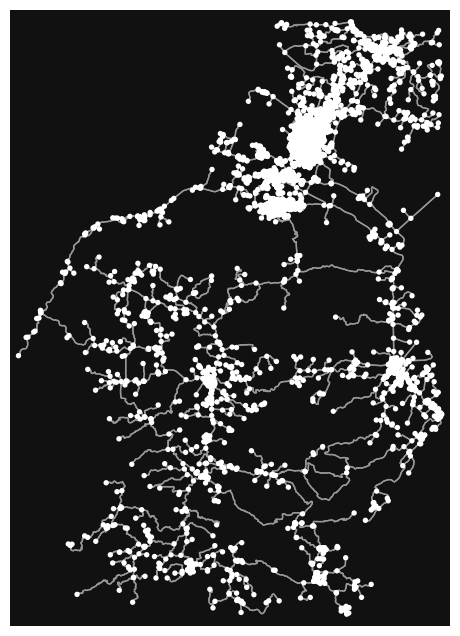

In [13]:

def get_bounding_box(query):
    url = "https://nominatim.openstreetmap.org/search"
    params = {
        "q": query,
        "format": "json",
        "limit": 1,
    }

    response = requests.get(url, params=params)
    result = response.json()
    return [float(coord) for coord in result[0]['boundingbox']]

bbox_norte = get_bounding_box("North Upi, Philippines")
bbox_sur = get_bounding_box("Datu Blah T. Sinsuat, Philippines")
bbox_south_upi = get_bounding_box("South Upi, Philippines")
bbox_datu_odin_sinsuat = get_bounding_box("Datu Odin Sinsuat, Philippines")
bbox_cotabato_city = get_bounding_box("Cotabato City, Philippines")

# Combine the bounding boxes
south = min(bbox_norte[0], bbox_sur[0], bbox_south_upi[0], bbox_datu_odin_sinsuat[0], bbox_cotabato_city[0])
north = max(bbox_norte[1], bbox_sur[1], bbox_south_upi[1], bbox_datu_odin_sinsuat[1], bbox_cotabato_city[1])
west = min(bbox_norte[2], bbox_sur[2], bbox_south_upi[2], bbox_datu_odin_sinsuat[2], bbox_cotabato_city[2])
east = max(bbox_norte[3], bbox_sur[3], bbox_south_upi[3], bbox_datu_odin_sinsuat[3], bbox_cotabato_city[3])

# Retrieve the road network for the combined bounding box
graph_2 = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# Plot the road network
fig, ax = ox.plot_graph(graph_2)


In [14]:
end_point = (7.0198506, 124.1646850)
end_node = ox.distance.nearest_nodes(graph_2, X=[end_point[1]], Y=[end_point[0]])[0]

In [15]:
# Add a travel time attribute to the edges, assuming an average speed of 30 km/h
for u, v, data in graph_2.edges(data=True):
    data['travel_time'] = data['length'] / (30 * 1000 / 3600)  # Convert the average speed to m/s

stats = ox.stats.basic_stats(graph_2, area=None)

# Calculate the total travel time in seconds
total_travel_time = sum(data['travel_time'] for u, v, data in graph_2.edges(data=True))

# Calculate the average speed in km/h
avg_speed = (stats['edge_length_total'] / 1000) / (total_travel_time / 3600)

print(f"Average speed: {avg_speed:.2f} km/h")

# Find the nodes that are within the desired access time
desired_access_time = 60  # minutes
# avg_speed = 30  # km/h
nodes_within_time = {}
for node in graph_2.nodes():
    try:
        path_length = nx.shortest_path_length(graph_2, end_node, node, weight='length')
        travel_time = (path_length / 1000) / avg_speed * 60  # Convert to minutes
        if travel_time <= desired_access_time:
            nodes_within_time[node] = travel_time
    except nx.NetworkXNoPath:
        continue

Average speed: 30.00 km/h


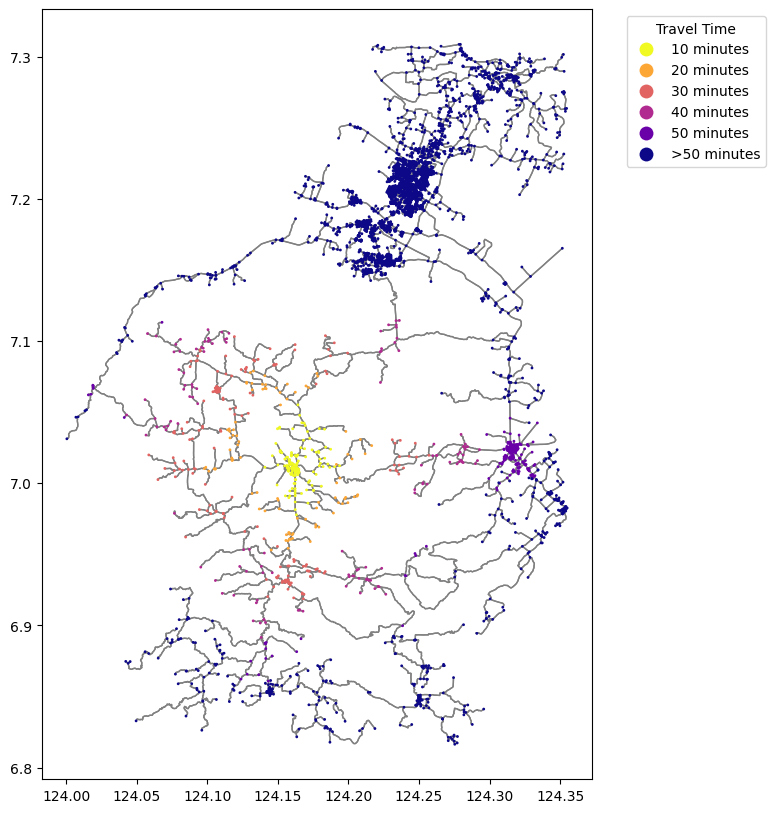

In [16]:
# Find the shortest path lengths (in minutes) from the end_node to all other nodes
shortest_paths = nx.shortest_path_length(graph_2, source=end_node, weight='travel_time')
shortest_paths_minutes = {node: length / 60 for node, length in shortest_paths.items()}

# Convert the graph to a GeoDataFrame
nodes, edges = ox.graph_to_gdfs(graph_2)

# Add the travel times to the nodes DataFrame
nodes['travel_time'] = nodes.index.map(shortest_paths_minutes)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the road network on the bottom layer
edges = gpd.GeoDataFrame(edges)
edges.plot(ax=ax, linewidth=1, color='gray', zorder=1)

# Plot the isochrone points on the top layer
iso_colors = ox.plot.get_colors(n=5, cmap='plasma', start=0, return_hex=True)
isochrone_intervals = [10, 20, 30, 40, 50]  # Define your desired isochrone intervals (in minutes)
nodes.plot(column='travel_time', cmap='plasma_r', scheme='User_Defined', ax=ax,
           classification_kwds={'bins': isochrone_intervals}, legend=True,
           markersize=1, zorder=2)

# Customize the appearance of the legend
legend = ax.get_legend()
for i, label in enumerate(legend.get_texts()[:-1]):
    label.set_text(f"{isochrone_intervals[i]:.0f} minutes")
legend.get_texts()[-1].set_text(f">{isochrone_intervals[-1]:.0f} minutes")
legend.set_title("Travel Time")
legend.set_bbox_to_anchor((1.05, 1))
legend.loc = 'upper left'

plt.show()


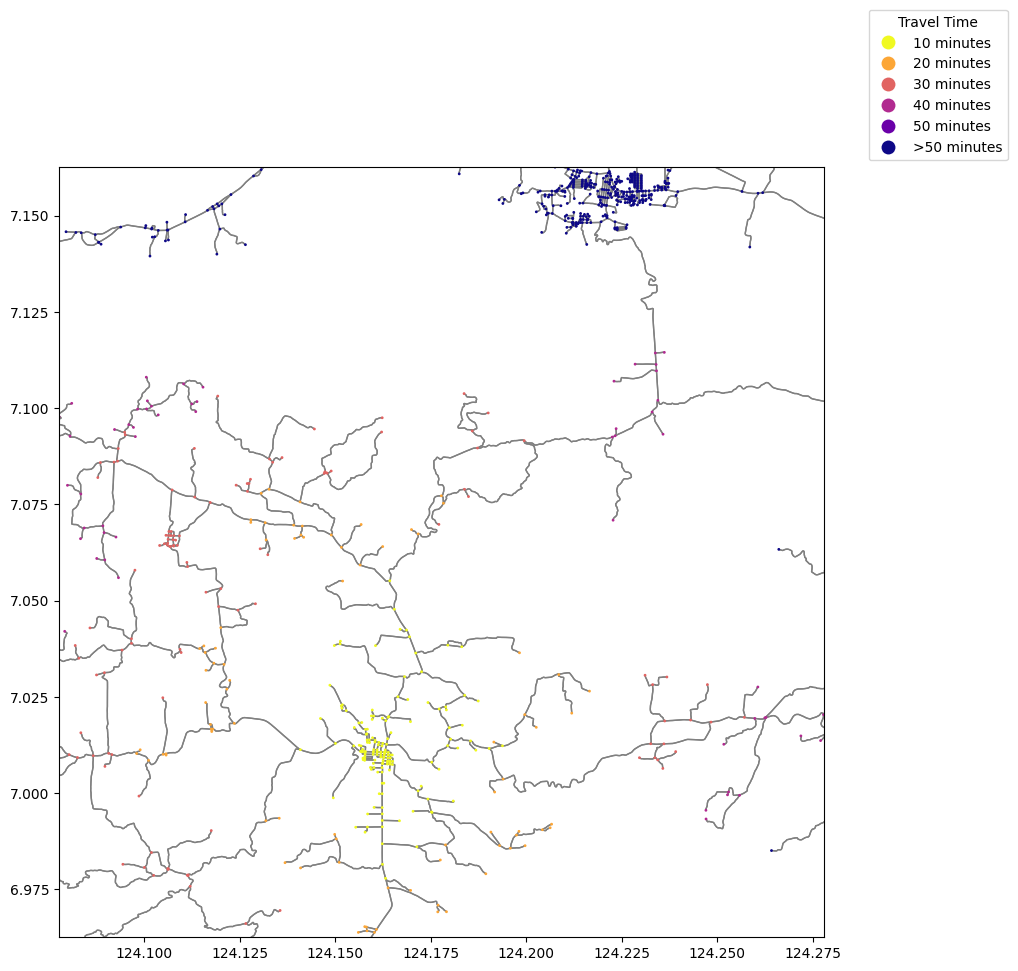

In [17]:
# Find the shortest path lengths (in minutes) from the end_node to all other nodes
shortest_paths = nx.shortest_path_length(graph_2, source=end_node, weight='travel_time')
shortest_paths_minutes = {node: length / 60 for node, length in shortest_paths.items()}

# Convert the graph to a GeoDataFrame
nodes, edges = ox.graph_to_gdfs(graph_2)

# Add the travel times to the nodes DataFrame
nodes['travel_time'] = nodes.index.map(shortest_paths_minutes)

# Create a new figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the road network on the bottom layer
edges = gpd.GeoDataFrame(edges)
edges.plot(ax=ax, linewidth=1, color='gray', zorder=1)

# Plot the isochrone points on the top layer
iso_colors = ox.plot.get_colors(n=5, cmap='plasma', start=0, return_hex=True)
isochrone_intervals = [10, 20, 30, 40, 50]  # Define your desired isochrone intervals (in minutes)
nodes.plot(column='travel_time', cmap='plasma_r', scheme='User_Defined', ax=ax,
           classification_kwds={'bins': isochrone_intervals}, legend=True,
           markersize=1, zorder=2)

# Customize the appearance of the legend
legend = ax.get_legend()
for i, label in enumerate(legend.get_texts()[:-1]):
    label.set_text(f"{isochrone_intervals[i]:.0f} minutes")
legend.get_texts()[-1].set_text(f">{isochrone_intervals[-1]:.0f} minutes")
legend.set_title("Travel Time")
legend.set_bbox_to_anchor((1.05, 1))
legend.loc = 'upper left'

# Zoom in on the middle of the plot
x_center = nodes.total_bounds[0] + (nodes.total_bounds[2] - nodes.total_bounds[0]) / 2
y_center = nodes.total_bounds[1] + (nodes.total_bounds[3] - nodes.total_bounds[1]) / 2
ax.set_xlim(x_center - 0.1, x_center + 0.1)
ax.set_ylim(y_center - 0.1, y_center + 0.1)

plt.show()

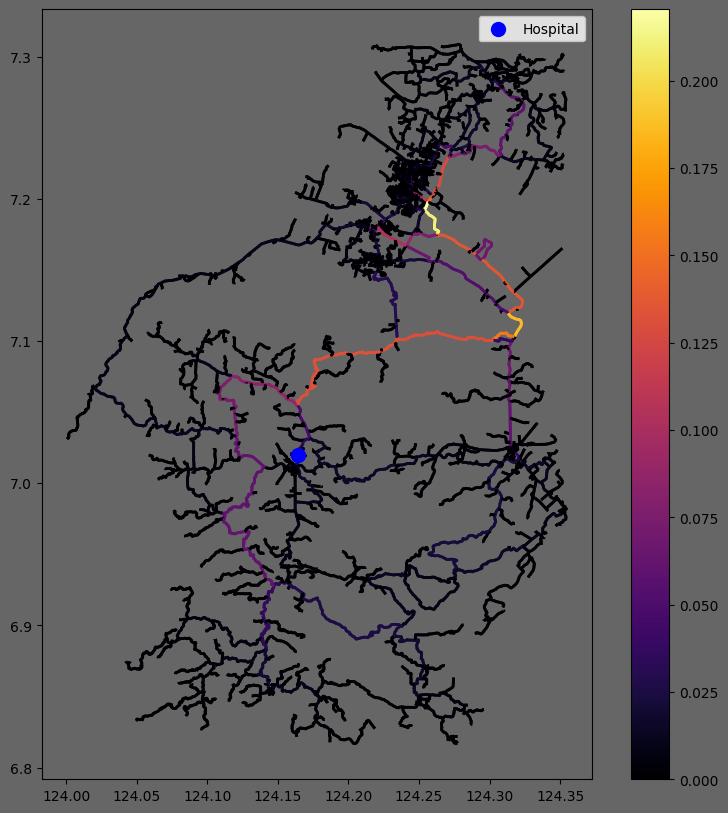

In [18]:
# Calculate edge betweenness centrality
edge_centrality = nx.edge_betweenness_centrality(graph_2)

# Add edge centrality to the graph as an attribute
nx.set_edge_attributes(graph_2, edge_centrality, "edge_centrality")

# Convert the graph to a GeoDataFrame
edges_gdf = ox.graph_to_gdfs(graph_2, nodes=False)

# Plot the graph with the colored edges
fig, ax = plt.subplots(figsize=(10, 10))
# Set the background color to black
ax.set_facecolor('#666666')
fig.patch.set_facecolor('#666666')

edges_gdf.plot(ax=ax, column="edge_centrality", cmap="inferno", linewidth=2, legend=True, zorder=1)

# Define the end point
end_point = (7.0198506, 124.1646850)

# Find the nearest node to the end_point
end_node = ox.distance.nearest_nodes(graph_2, X=[end_point[1]], Y=[end_point[0]])[0]

# Get the x and y coordinates of the end_node
end_node_x, end_node_y = graph_2.nodes[end_node]['x'], graph_2.nodes[end_node]['y']

# Plot the specific node (end_node) on the graph
ax.scatter(end_node_x, end_node_y, c='blue', zorder=10, s=100, label='Hospital')

# Add a legend to the plot
ax.legend()


# Show the plot
plt.show()


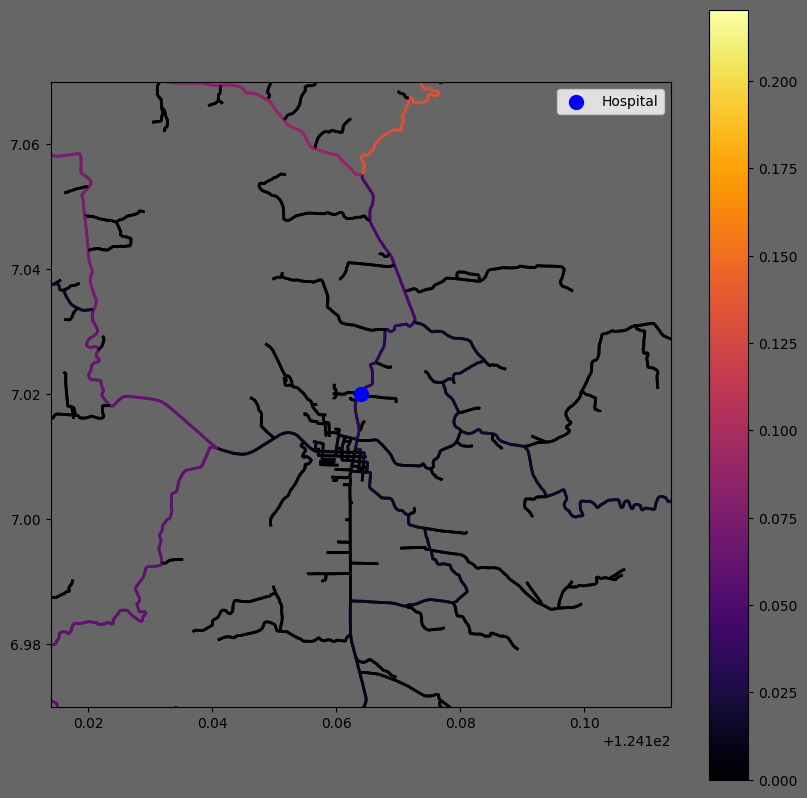

In [19]:
# Convert the graph to a GeoDataFrame
edges_gdf = ox.graph_to_gdfs(graph_2, nodes=False)

# Plot the graph with the colored edges
fig, ax = plt.subplots(figsize=(10, 10))
# Set the background color to black
ax.set_facecolor('#666666')
fig.patch.set_facecolor('#666666')

edges_gdf.plot(ax=ax, column="edge_centrality", cmap="inferno", linewidth=2, legend=True, zorder=1)

# Define the end point
end_point = (7.0198506, 124.1646850)

# Find the nearest node to the end_point
end_node = ox.distance.nearest_nodes(graph_2, X=[end_point[1]], Y=[end_point[0]])[0]

# Get the x and y coordinates of the end_node
end_node_x, end_node_y = graph_2.nodes[end_node]['x'], graph_2.nodes[end_node]['y']

# Plot the specific node (end_node) on the graph
ax.scatter(end_node_x, end_node_y, c='blue', zorder=10, s=100, label='Hospital')

# Add a legend to the plot
ax.legend()

# Set plot limits to zoom into the middle
margin = 0.05
west, south, east, north = end_node_x - margin, end_node_y - margin, end_node_x + margin, end_node_y + margin
ax.set_xlim(west, east)
ax.set_ylim(south, north)

# Show the plot
plt.show()


In [20]:
# Load the map center from the pickle
with open('pickles/folium_center.pkl', 'rb') as f:
    map_center = pickle.load(f)

# Create the Folium map
overlay = folium.Map(location=map_center, zoom_start=8)

# Convert the graph to GeoDataFrames
nodes, edges = ox.graph_to_gdfs(graph_2)

# Convert the edges GeoDataFrame to GeoJSON
edges_geojson = json.loads(edges.to_json())

# Create a GeoJson layer from the GeoJSON data
geojson_layer = folium.GeoJson(edges_geojson, name="Road Network")

# Add the GeoJson layer to the Folium map
geojson_layer.add_to(overlay)

# Add color-coded markers for the nodes
for node, data in nodes.iterrows():
    if node == end_node:
        color = 'purple'
        radius = 5  # Set the end_node size larger
    elif node in nodes_within_time:
        color = 'green'
        radius = 1
    else:
        color = 'red'
        radius = 1
    folium.CircleMarker(location=(data['y'], data['x']),
                        radius=radius,
                        color=color,
                        fill=True,
                        fill_color=color,
                        fill_opacity=0.7).add_to(overlay)

# Save the map to an HTML file
overlay.save('map_output_3.html')
# Show the map
# overlay